In [1]:
import os,shutil,sys
sys.path.append('/data/py/lib/') 
import keras
import time
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.applications import xception
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
####定义一些常用的训练调整参数###########
epochs=20          #定义训练轮数
batch_size=20       #每批数量
lock_layer_num=70;   #锁住的层数
lr=1e-5             #学习率
dense_num=256       #连接层数量
pre_train_epochs=1#预训练轮数,0表示不进行预训练
img_height=299      #训练图片高度
img_width=299       #训练图片宽度
is_load_model=False #是否加载自己训练的历史模型
model_path="/data/keras/models/01281643.h"
##########################

base_dir='/data/keras/download/hua'
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')


mod_names=["月季花","蝴蝶兰","海棠花","桂花","发财树","米仔兰","一品红","九里香","茶花","巴西铁树"]

mod_num=len(mod_names)


Using TensorFlow backend.


In [2]:

#使用图片数据增强，降低拟合的有效手段
train_datagen=ImageDataGenerator(  
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#验证，测试数据不能进行数据增强
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'   
)

validation_generator=test_datagen.flow_from_directory(   
    validation_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator=test_datagen.flow_from_directory(   
    test_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2988 images belonging to 10 classes.
Found 499 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [3]:
if is_load_model is False:
    # 构建不带分类器的预训练模型
    base_model = xception.Xception(weights="imagenet",include_top=False,input_shape=(img_height,img_width,3))

    # 添加全局平均池化层
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # 添加一个全连接层
    x = Dense(dense_num, activation='relu')(x)

    # 添加一个分类器
    predictions = Dense(mod_num, activation='softmax')(x)

    # 构建我们需要训练的完整模型
    model = Model(inputs=base_model.input, outputs=predictions)

    # 锁住所有 Xception 的卷积层
    for layer in base_model.layers:
        layer.trainable = False

    #预训练
    if pre_train_epochs>0:
        model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=['acc'])
        history=model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/train_generator.batch_size,
            epochs=pre_train_epochs,
            validation_data=validation_generator,
            validation_steps=validation_generator.n/validation_generator.batch_size
        )

    # 现在顶层应该训练好了，开始微调 Xception的卷积层。
    # 锁住底下的几层，然后训练其余的顶层。
    # 看看每一层的名字和层号，看看我们应该锁多少层呢：
    # for i, layer in enumerate(base_model.layers):
    #    print(i, layer.name)

    # 锁住的层数
    for layer in model.layers[:lock_layer_num]:
       layer.trainable = False
    for layer in model.layers[lock_layer_num:]:
       layer.trainable = True

    # 设置一个很低的学习率，使用 SGD 来微调
    from keras.optimizers import SGD
    model.compile(optimizer=optimizers.RMSprop(lr=lr), loss='categorical_crossentropy',metrics=['acc'])

    # 继续训练模型
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n/train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.n/validation_generator.batch_size
    )
    #保存训练好的模型
    time_t=time.strftime("%m%d%H%M", time.localtime()) 
    model.save('/data/keras/models/hua_%s.h'%time_t)


Epoch 1/1
150/149 [==============================] - 53s 351ms/step - loss: 1.8881 - acc: 0.4283 - val_loss: 1.6222 - val_acc: 0.4569
Epoch 1/20
150/149 [==============================] - 53s 356ms/step - loss: 1.3123 - acc: 0.6302 - val_loss: 1.1633 - val_acc: 0.6954
Epoch 2/20
150/149 [==============================] - 49s 324ms/step - loss: 1.0169 - acc: 0.7070 - val_loss: 0.9638 - val_acc: 0.7134
Epoch 3/20
150/149 [==============================] - 49s 324ms/step - loss: 0.8582 - acc: 0.7500 - val_loss: 0.8469 - val_acc: 0.7475
Epoch 4/20
150/149 [==============================] - 49s 328ms/step - loss: 0.7342 - acc: 0.7852 - val_loss: 0.7618 - val_acc: 0.7756
Epoch 5/20
150/149 [==============================] - 49s 324ms/step - loss: 0.6687 - acc: 0.7997 - val_loss: 0.6916 - val_acc: 0.7896
Epoch 6/20
150/149 [==============================] - 48s 323ms/step - loss: 0.5923 - acc: 0.8247 - val_loss: 0.6089 - val_acc: 0.8236
Epoch 7/20
150/149 [==============================] - 49

In [4]:
# history=model.fit_generator(
#     train_generator,
#     steps_per_epoch=train_generator.n/train_generator.batch_size,
#     epochs=5,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.n/validation_generator.batch_size
# )
# #保存训练好的模型
# time_t=time.strftime("%m%d%H%M", time.localtime()) 
# model.save('/data/keras/models/%s.h'%time_t)

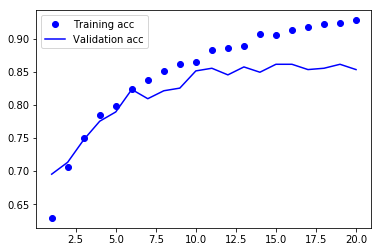

<Figure size 432x288 with 0 Axes>

In [5]:
#显示训练过程中精度变化
if is_load_model is False:
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(1,len(acc)+1)
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.legend()
    plt.figure()
    plt.show()
else:
    model=keras.models.load_model("/data/keras/models/01281643.h")

In [6]:
#测试集评估
test_loss,test_acc=model.evaluate_generator(test_generator,steps=test_generator.n/test_generator.batch_size)
print ("测试集 acc:%f" % (test_acc))

测试集 acc:0.869347


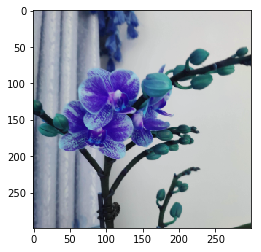

图片： /data/test/hua/蝴蝶兰1.jpg
预测： [('蝴蝶兰', 0.548691), ('海棠花', 0.41890636), ('茶花', 0.012727112), ('月季花', 0.010150977), ('一品红', 0.0032245833), ('九里香', 0.0021339695), ('米仔兰', 0.0012889332), ('巴西铁树', 0.0012219328), ('桂花', 0.0009850507), ('发财树', 0.00067012064)]


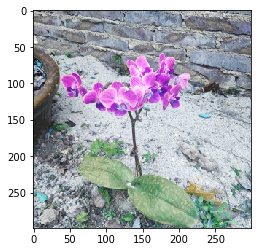

图片： /data/test/hua/蝴蝶兰2.jpg
预测： [('蝴蝶兰', 0.936769), ('月季花', 0.039718684), ('海棠花', 0.012492949), ('茶花', 0.007109828), ('九里香', 0.0007884579), ('一品红', 0.00077634986), ('桂花', 0.00068473903), ('巴西铁树', 0.0006626138), ('米仔兰', 0.0005621988), ('发财树', 0.00043523745)]


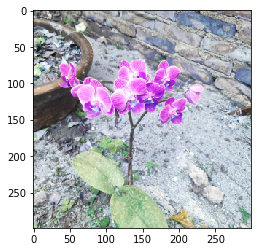

图片： /data/test/hua/蝴蝶兰3.jpg
预测： [('蝴蝶兰', 0.98347336), ('月季花', 0.009097983), ('海棠花', 0.0028328134), ('茶花', 0.0025127404), ('巴西铁树', 0.00048952113), ('发财树', 0.00040616898), ('桂花', 0.0003979659), ('九里香', 0.00038682137), ('米仔兰', 0.00021081044), ('一品红', 0.0001917294)]


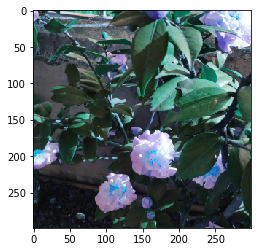

图片： /data/test/hua/茶花2.jpg
预测： [('茶花', 0.52972096), ('月季花', 0.28309473), ('海棠花', 0.09939424), ('桂花', 0.056347452), ('蝴蝶兰', 0.01126412), ('米仔兰', 0.006926025), ('九里香', 0.004311205), ('发财树', 0.004206327), ('巴西铁树', 0.0035264057), ('一品红', 0.0012085683)]


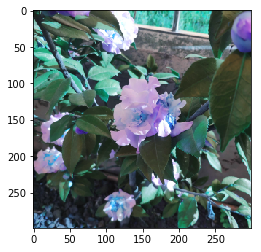

图片： /data/test/hua/茶花3.jpg
预测： [('海棠花', 0.49970317), ('茶花', 0.26705828), ('月季花', 0.22116384), ('蝴蝶兰', 0.0031894695), ('桂花', 0.0029815296), ('一品红', 0.0027205476), ('米仔兰', 0.0012003934), ('九里香', 0.0010260388), ('发财树', 0.0007075344), ('巴西铁树', 0.0002492278)]


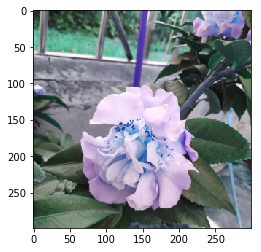

图片： /data/test/hua/茶花4.jpg
预测： [('茶花', 0.8890562), ('海棠花', 0.085895546), ('月季花', 0.022565749), ('九里香', 0.0009217435), ('蝴蝶兰', 0.00076695974), ('一品红', 0.00034422512), ('桂花', 0.0002700419), ('米仔兰', 0.00011536874), ('巴西铁树', 5.1741943e-05), ('发财树', 1.2331008e-05)]


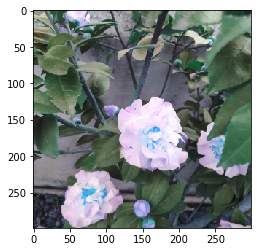

图片： /data/test/hua/茶花5.jpg
预测： [('茶花', 0.4766754), ('月季花', 0.34722093), ('海棠花', 0.14757131), ('蝴蝶兰', 0.009769733), ('九里香', 0.008236419), ('一品红', 0.0035326749), ('桂花', 0.0034906457), ('米仔兰', 0.0014997303), ('发财树', 0.001245922), ('巴西铁树', 0.00075722614)]


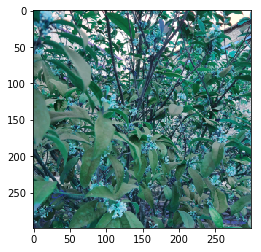

图片： /data/test/hua/桂花1.jpg
预测： [('桂花', 0.88445604), ('巴西铁树', 0.044972356), ('米仔兰', 0.036408063), ('茶花', 0.01863688), ('发财树', 0.0066569755), ('九里香', 0.00604469), ('蝴蝶兰', 0.0014247344), ('月季花', 0.00063577306), ('海棠花', 0.00062369485), ('一品红', 0.00014087999)]


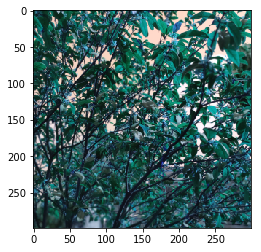

图片： /data/test/hua/桂花2.jpg
预测： [('桂花', 0.9492582), ('米仔兰', 0.0205586), ('海棠花', 0.010778706), ('茶花', 0.009120098), ('发财树', 0.005101123), ('巴西铁树', 0.0021469055), ('九里香', 0.0014599632), ('月季花', 0.0007579529), ('一品红', 0.00042584582), ('蝴蝶兰', 0.00039262365)]


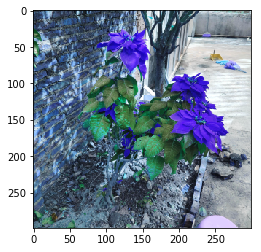

图片： /data/test/hua/一品红1.jpg
预测： [('一品红', 0.7262588), ('茶花', 0.14967057), ('海棠花', 0.03910496), ('蝴蝶兰', 0.03695106), ('月季花', 0.02296917), ('发财树', 0.014271879), ('九里香', 0.0055290596), ('巴西铁树', 0.0023021584), ('桂花', 0.0018793127), ('米仔兰', 0.0010630093)]


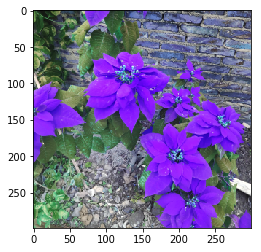

图片： /data/test/hua/一品红2.jpg
预测： [('一品红', 0.9456659), ('发财树', 0.010964634), ('海棠花', 0.00946384), ('九里香', 0.0059429826), ('米仔兰', 0.005891346), ('桂花', 0.005739299), ('月季花', 0.0055713044), ('蝴蝶兰', 0.0048558456), ('茶花', 0.0037058902), ('巴西铁树', 0.0021988386)]


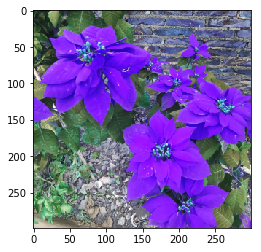

图片： /data/test/hua/一品红3.jpg
预测： [('一品红', 0.9133103), ('海棠花', 0.05822425), ('月季花', 0.009942146), ('桂花', 0.005022418), ('茶花', 0.004822986), ('九里香', 0.0035232103), ('米仔兰', 0.0019978362), ('蝴蝶兰', 0.0015767888), ('发财树', 0.0010490149), ('巴西铁树', 0.0005311142)]


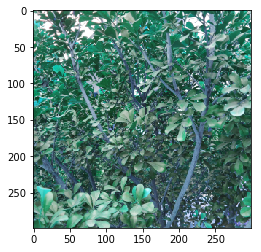

图片： /data/test/hua/米仔兰2.jpg
预测： [('米仔兰', 0.4712873), ('桂花', 0.3541058), ('九里香', 0.10445177), ('茶花', 0.03802018), ('发财树', 0.012365902), ('巴西铁树', 0.011406301), ('月季花', 0.0030445326), ('蝴蝶兰', 0.0027287127), ('海棠花', 0.002102372), ('一品红', 0.00048712338)]


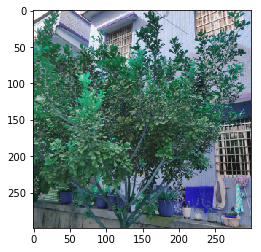

图片： /data/test/hua/米仔兰3.jpg
预测： [('米仔兰', 0.6151785), ('九里香', 0.366227), ('桂花', 0.011127132), ('发财树', 0.0035205868), ('海棠花', 0.0019278323), ('月季花', 0.0006168493), ('一品红', 0.0004512722), ('巴西铁树', 0.0004376169), ('茶花', 0.0002688281), ('蝴蝶兰', 0.0002442913)]


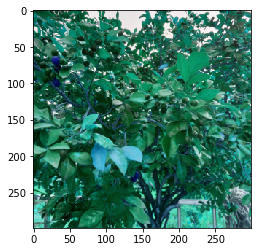

图片： /data/test/hua/九里香1.jpg
预测： [('桂花', 0.55991536), ('米仔兰', 0.25197566), ('发财树', 0.09233484), ('九里香', 0.07612937), ('巴西铁树', 0.00940101), ('茶花', 0.0069059683), ('一品红', 0.0010593852), ('月季花', 0.00093557633), ('海棠花', 0.0007517047), ('蝴蝶兰', 0.00059106253)]


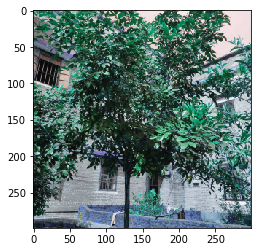

图片： /data/test/hua/九里香2.jpg
预测： [('九里香', 0.5930295), ('米仔兰', 0.19282244), ('桂花', 0.08694335), ('发财树', 0.05676182), ('海棠花', 0.02972017), ('茶花', 0.017179538), ('巴西铁树', 0.00993939), ('一品红', 0.005070808), ('月季花', 0.004945137), ('蝴蝶兰', 0.0035878439)]


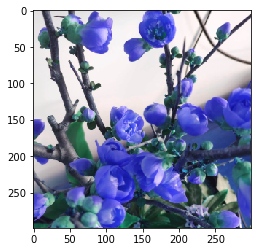

图片： /data/test/hua/海棠花2.jpg
预测： [('海棠花', 0.8345101), ('蝴蝶兰', 0.1171042), ('月季花', 0.026193015), ('茶花', 0.008538389), ('九里香', 0.00788602), ('米仔兰', 0.0031763483), ('一品红', 0.0016355953), ('桂花', 0.00043083937), ('巴西铁树', 0.00041233166), ('发财树', 0.00011312907)]


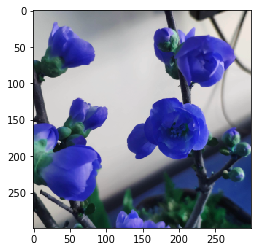

图片： /data/test/hua/海棠花3.jpg
预测： [('海棠花', 0.83133984), ('蝴蝶兰', 0.12181787), ('月季花', 0.021577995), ('茶花', 0.021205815), ('一品红', 0.0016368427), ('九里香', 0.0007503584), ('桂花', 0.00070211623), ('米仔兰', 0.0005431533), ('巴西铁树', 0.00029374973), ('发财树', 0.00013217679)]


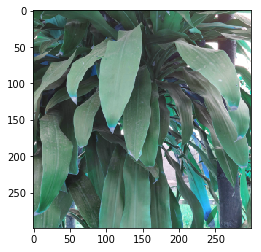

图片： /data/test/hua/巴西铁树1.jpg
预测： [('巴西铁树', 0.87514293), ('桂花', 0.029615656), ('茶花', 0.029282965), ('发财树', 0.027190994), ('米仔兰', 0.014524813), ('蝴蝶兰', 0.011915747), ('九里香', 0.008005723), ('一品红', 0.0025227943), ('月季花', 0.00096187985), ('海棠花', 0.00083653815)]


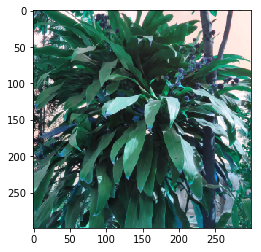

图片： /data/test/hua/巴西铁树2.jpg
预测： [('巴西铁树', 0.53754324), ('发财树', 0.13803631), ('九里香', 0.090268984), ('米仔兰', 0.08991422), ('茶花', 0.07026498), ('桂花', 0.040130656), ('一品红', 0.013824217), ('海棠花', 0.00818768), ('蝴蝶兰', 0.0065002674), ('月季花', 0.005329415)]


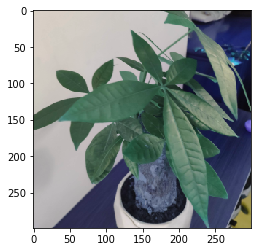

图片： /data/test/hua/发财树1.jpg
预测： [('发财树', 0.9786203), ('桂花', 0.009063286), ('巴西铁树', 0.004941247), ('九里香', 0.0026988455), ('米仔兰', 0.0019849772), ('一品红', 0.0011503922), ('茶花', 0.0007147121), ('蝴蝶兰', 0.0004617229), ('海棠花', 0.0002888221), ('月季花', 7.5714706e-05)]


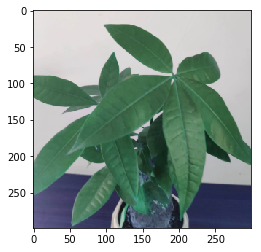

图片： /data/test/hua/发财树2.jpg
预测： [('发财树', 0.94645697), ('桂花', 0.049496345), ('巴西铁树', 0.002310783), ('米仔兰', 0.0004228667), ('一品红', 0.00041253387), ('九里香', 0.000401107), ('茶花', 0.00021619619), ('蝴蝶兰', 0.00016059427), ('海棠花', 0.00010807464), ('月季花', 1.4498891e-05)]


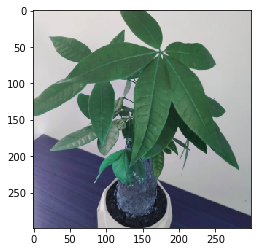

图片： /data/test/hua/发财树3.jpg
预测： [('发财树', 0.9790774), ('桂花', 0.014386709), ('巴西铁树', 0.0053664953), ('九里香', 0.00040266546), ('米仔兰', 0.00039417623), ('蝴蝶兰', 0.00017719147), ('茶花', 0.00011311835), ('一品红', 5.7665053e-05), ('海棠花', 1.5861779e-05), ('月季花', 8.807134e-06)]


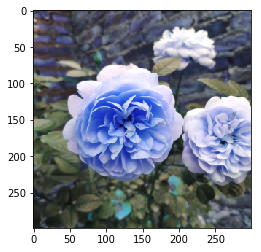

图片： /data/test/hua/月季花3.jpg
预测： [('月季花', 0.8501827), ('茶花', 0.12414731), ('蝴蝶兰', 0.0091410605), ('海棠花', 0.008203169), ('九里香', 0.0028496569), ('一品红', 0.0017173914), ('桂花', 0.0013077436), ('巴西铁树', 0.001275328), ('发财树', 0.0005906814), ('米仔兰', 0.00058496115)]


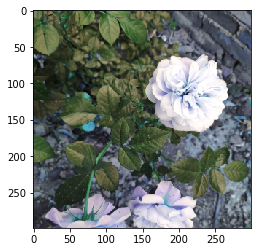

图片： /data/test/hua/月季花4.jpg
预测： [('月季花', 0.8787797), ('茶花', 0.09360167), ('海棠花', 0.02135569), ('一品红', 0.0020695832), ('米仔兰', 0.0014530838), ('九里香', 0.0013462545), ('桂花', 0.00073625956), ('发财树', 0.00024946826), ('巴西铁树', 0.00021908365), ('蝴蝶兰', 0.00018922736)]


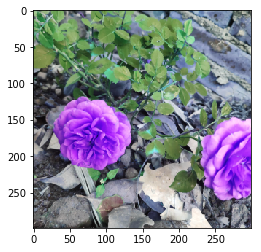

图片： /data/test/hua/月季花7.jpg
预测： [('月季花', 0.96820503), ('茶花', 0.031011144), ('海棠花', 0.00018116435), ('蝴蝶兰', 0.000116962576), ('巴西铁树', 0.00010899658), ('九里香', 0.00010663141), ('米仔兰', 9.731797e-05), ('桂花', 6.9103946e-05), ('一品红', 5.8818925e-05), ('发财树', 4.4810753e-05)]


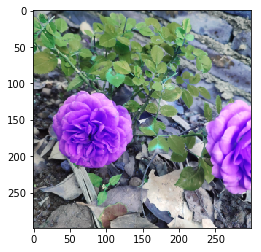

图片： /data/test/hua/月季花8.jpg
预测： [('月季花', 0.92973673), ('茶花', 0.06952587), ('海棠花', 0.00019421832), ('九里香', 0.00010424181), ('蝴蝶兰', 8.817011e-05), ('桂花', 8.7952685e-05), ('米仔兰', 8.0139434e-05), ('巴西铁树', 7.3434116e-05), ('一品红', 6.777589e-05), ('发财树', 4.1443254e-05)]


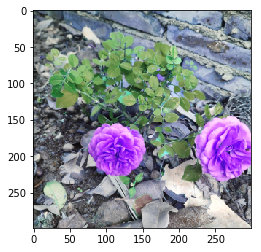

图片： /data/test/hua/月季花9.jpg
预测： [('月季花', 0.97884136), ('茶花', 0.020384975), ('九里香', 0.00023030593), ('海棠花', 0.00019580792), ('蝴蝶兰', 0.00014724012), ('米仔兰', 6.954362e-05), ('一品红', 5.1092215e-05), ('桂花', 4.371508e-05), ('巴西铁树', 2.6682002e-05), ('发财树', 9.214583e-06)]


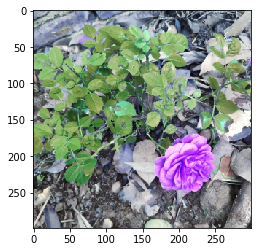

图片： /data/test/hua/月季花10.jpg
预测： [('月季花', 0.9885908), ('茶花', 0.009934339), ('九里香', 0.0006206857), ('海棠花', 0.00046302244), ('米仔兰', 0.00019229486), ('桂花', 8.42358e-05), ('一品红', 8.1725695e-05), ('巴西铁树', 1.476359e-05), ('蝴蝶兰', 1.3065069e-05), ('发财树', 4.97947e-06)]


In [7]:
#显示真实收集的图片的结果
from keras.preprocessing import image
import numpy as np
import cv2
from mytool import MyTool
test_imgs=['/data/test/hua/蝴蝶兰1.jpg',
           '/data/test/hua/蝴蝶兰2.jpg',
           '/data/test/hua/蝴蝶兰3.jpg',
           '/data/test/hua/茶花2.jpg',
           '/data/test/hua/茶花3.jpg',
           '/data/test/hua/茶花4.jpg',
           '/data/test/hua/茶花5.jpg',
           '/data/test/hua/桂花1.jpg',
            '/data/test/hua/桂花2.jpg',
            '/data/test/hua/一品红1.jpg',
           '/data/test/hua/一品红2.jpg',
           '/data/test/hua/一品红3.jpg',
           '/data/test/hua/米仔兰2.jpg',
           '/data/test/hua/米仔兰3.jpg',
           '/data/test/hua/九里香1.jpg',
           '/data/test/hua/九里香2.jpg',
           '/data/test/hua/海棠花2.jpg',
           '/data/test/hua/海棠花3.jpg',
           '/data/test/hua/巴西铁树1.jpg',
           '/data/test/hua/巴西铁树2.jpg',
           '/data/test/hua/发财树1.jpg',
           '/data/test/hua/发财树2.jpg',
           '/data/test/hua/发财树3.jpg',
           '/data/test/hua/月季花3.jpg',
           '/data/test/hua/月季花4.jpg',
           '/data/test/hua/月季花7.jpg',
           '/data/test/hua/月季花8.jpg',
           '/data/test/hua/月季花9.jpg',
           '/data/test/hua/月季花10.jpg',
          ]

for img_path in test_imgs:
    #img = image.load_img(img_path, target_size=(img_height, img_width))
    img =cv2.imread(img_path)
#     plt.imshow(img)
#     plt.show()
    img=MyTool.cro_img(img,img_height,img_width)
    plt.imshow(img)
    plt.show()
    
    x = image.img_to_array(img)
    x=x/255
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    paixu=dict(zip(train_generator.class_indices,preds[0]))
    paixu= sorted(paixu.items(), key=lambda x: x[1], reverse=True)
    print("图片：",img_path)
    print("预测：",paixu)